<h1>I'm Something of a Painter Myself</h1>
<a id='Intro'></a>
<h1>Project Goal</h1>
The purpose of this competition is to create paintings using generative adversarial networks (GANs) without having to use paint, brushes, or any of the artistic materials that are often used by artists such as Monet, Picasso, or Kahlo, to name a few. Use neural networks and computer vision to "paint" anywhere between 7,000 and 10,000 images.
<br>



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import key visualization libraries 
# Import tensorflow for model training and layering

import tensorflow as tf
# from tensorflow import keras
from keras import layers, models, optimizers

import matplotlib.pyplot as plt
import PIL.Image

2025-06-27 10:52:32.901163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751021553.088652      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751021553.143633      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id='EDA'></a>
# Exploratory Data Analysis

Let's get to know some more information about the image-based data that we will be working with in this activity.

In [3]:
# Get how many images are in the Monet JPG directory
len(os.listdir('/kaggle/input/gan-getting-started/monet_jpg'))

300

In [4]:
# Get how many images are in the photo_jpg directory
len(os.listdir('/kaggle/input/gan-getting-started/photo_jpg'))

7038

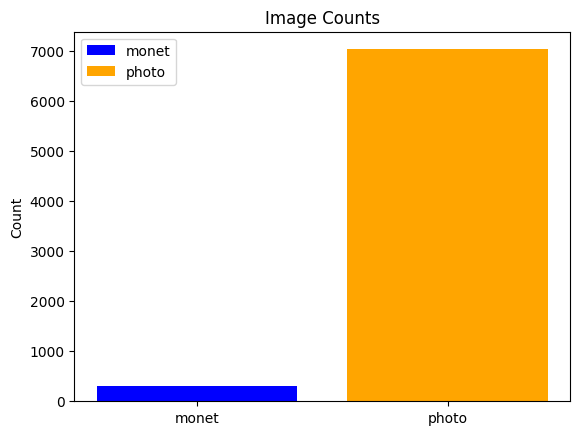

In [5]:
# Plot how many images are in each directory
labels = ['monet', 'photo']
img_count = [len(os.listdir('/kaggle/input/gan-getting-started/monet_jpg')), len(os.listdir('/kaggle/input/gan-getting-started/photo_jpg'))]
plt.bar(labels[0], img_count[0], color='blue')
plt.bar(labels[1], img_count[1], color='orange')
plt.title('Image Counts')
plt.legend(['monet', 'photo'])
plt.ylabel('Count')
plt.show()

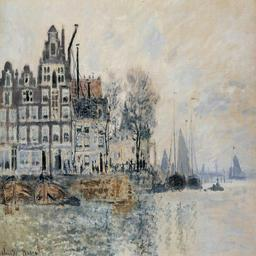

In [6]:
# Get one image from Monet_jpg directory to see what it looks like

from IPython.display import Image
Image("/kaggle/input/gan-getting-started/monet_jpg/064487d630.jpg")

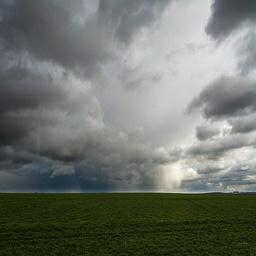

In [7]:
# Get one image from photo_jpg directory to see what it looks like

Image("/kaggle/input/gan-getting-started/photo_jpg/00104fd531.jpg")

In [8]:
# Get a batch of images and get image dimensions

# First initialize paths to monet_jpg, photo_jpg directories
monet_path = '/kaggle/input/gan-getting-started/monet_jpg/'
photo_path = '/kaggle/input/gan-getting-started/photo_jpg/'

In [9]:
# Function to show some images, however many at a time
# Also return dimensions of each image

def show_samples(fpath, artist, number):
    plt.figure(figsize=[10,8])
    images = os.listdir(fpath)[:number]
    for each, img_name in enumerate(images):
        img = PIL.Image.open(os.path.join(fpath, img_name))
        print(img.size)
        plt.subplot(1, number, each+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


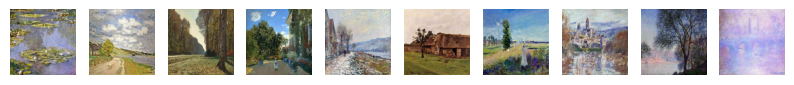

In [10]:
# Monet photos
show_samples(monet_path, "Monet Works", 10)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


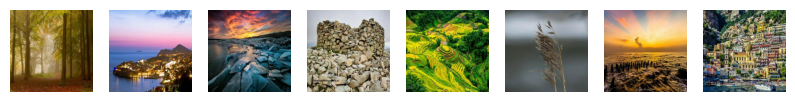

In [11]:
# photo_jpg images
show_samples(photo_path, "Photo Works", 8)

<a id='Preprocessing'></a>
# Image Preprocessing

Load images, check if a GPU is available, and make sure all image directories and TFRecords are aligned properly prior to running any model to generate images. Make sure all images are loaded properly to avoid the risk of the model not recognizing the location of all the images. 

In [12]:
# Check if GPU is available - only on Colab or Kaggle

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU being used for training")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
else: # Use CPU
    BATCH_SIZE=16
    EPOCHS = 5
    print("Using CPU")

GPU being used for training
GPU Name: /physical_device:GPU:0
GPU Name: /physical_device:GPU:1


In [13]:
type(os.listdir('/kaggle/input/gan-getting-started/monet_jpg/'))

list

In [14]:
monet_listdir = os.listdir('/kaggle/input/gan-getting-started/monet_jpg/')
photo_listdir = os.listdir('/kaggle/input/gan-getting-started/photo_jpg/')

In [15]:
monet_listdir[0:4]

['f4413e97bd.jpg', '7341d96c1d.jpg', 'de6f71b00f.jpg', '99d94af5dd.jpg']

In [16]:
# Add full file extension to both monet, photo listdirs
# Make lambda functions to add full path to all images

monet_lambda = lambda x: monet_path + x
monet_ld = list(map(monet_lambda, monet_listdir))
monet_ld[0:4]

['/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg',
 '/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg',
 '/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg',
 '/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg']

In [17]:
photo_lambda = lambda x: photo_path + x
photo_ld = list(map(photo_lambda, photo_listdir))
photo_ld[0:4]

['/kaggle/input/gan-getting-started/photo_jpg/fb97febc5f.jpg',
 '/kaggle/input/gan-getting-started/photo_jpg/c54c5368af.jpg',
 '/kaggle/input/gan-getting-started/photo_jpg/4a06596662.jpg',
 '/kaggle/input/gan-getting-started/photo_jpg/2629524a69.jpg']

In [18]:
from keras.preprocessing.image import img_to_array, load_img

PIXELS = 256

# Perform image preprocessing and load images for monet_arr, photo_arr
monet_arr = np.array([img_to_array(load_img(image, target_size=(PIXELS, PIXELS)))
                                   for image in monet_ld])

In [19]:
photo_arr = np.array([img_to_array(load_img(image, target_size=(PIXELS, PIXELS)))
                                   for image in photo_ld])

In [20]:
# # This is what the numpy arrays look like
# monet_arr

<a id='Building'></a>
# Model Building

I will be using a custom CNN Sequential architecture using a generator and discriminator to be able to get this model to generate images as if it were Monet. 

In [21]:
# Build the discriminator's layers
def discriminator_layers():
    model = models.Sequential([
        
        layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(PIXELS, PIXELS), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [22]:
# Build the generator's layers
def generator_layers():
    model = models.Sequential([
        layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(PIXELS, PIXELS), padding='same', activation='relu'),
        
        layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model